In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm

In [24]:
all_weeks_global=pd.read_excel('all-weeks-global.xlsx')
all_weeks_global.head()

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,episode_launch_details
0,2023-11-19,Films (English),1,The Killer,NaN,44500000,2.0000,22300000.0,2,False,NaN
1,2023-11-19,Films (English),2,Best. Christmas. Ever!,NaN,22300000,1.3667,16300000.0,1,False,NaN
2,2023-11-19,Films (English),3,Monster Hunter,NaN,10500000,1.7167,6100000.0,1,False,NaN
3,2023-11-19,Films (English),4,Locked In,NaN,8200000,1.6167,5100000.0,3,False,NaN
4,2023-11-19,Films (English),5,F9: The Fast Saga,NaN,10200000,2.3833,4300000.0,4,False,NaN


In [25]:
df=all_weeks_global[['week','category','show_title','weekly_hours_viewed']].copy()
df

,week,category,show_title,weekly_hours_viewed
0,2023-11-19,Films (English),The Killer,44500000
1,2023-11-19,Films (English),Best. Christmas. Ever!,22300000
2,2023-11-19,Films (English),Monster Hunter,10500000
3,2023-11-19,Films (English),Locked In,8200000
4,2023-11-19,Films (English),F9: The Fast Saga,10200000
...,...,...,...,...
4995,2021-07-04,TV (Non-English),Elite,10530000
4996,2021-07-04,TV (Non-English),Elite,10200000
4997,2021-07-04,TV (Non-English),Elite,10140000
4998,2021-07-04,TV (Non-English),Katla,9190000


There are 4 different categories of Top 10, they are: 'Films English', 'Films (Non-English)', 'TV (English)' and 'TV (Non-English)'. Let's see how they compare in terms of Weekly Hours Viewed.

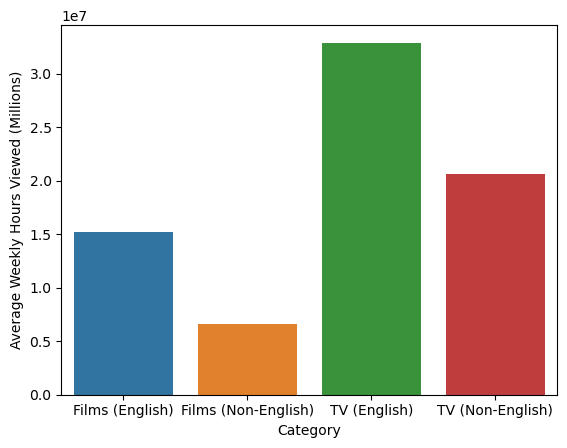

In [26]:
categories=df['category'].unique()
avg_weekly_hours_viewed_by_category=[]
for category in categories:
    avg_hours=df.loc[df['category']==category]['weekly_hours_viewed'].mean()
    avg_weekly_hours_viewed_by_category.append(avg_hours)
    
ax=sns.barplot(x=categories,y=avg_weekly_hours_viewed_by_category)
ax.set(xlabel='Category', ylabel='Average Weekly Hours Viewed (Millions)')
plt.show()

In [27]:
avg_weekly_hours_viewed_by_category[2]/np.sum(avg_weekly_hours_viewed_by_category)

0.436847771262779

On average, English TV Shows represent 43.68% of the weekly hours viewed. 

In [28]:
df.loc[df['category']=='TV (English)'].groupby(['show_title']).sum().sort_values(by='weekly_hours_viewed',ascending=False)

,weekly_hours_viewed
show_title,
Stranger Things,2967980000
Wednesday,1806850000
Manifest,1320520000
You,1245390000
The Witcher,1117900000
...,...
85 South: Ghetto Legends,2700000
Shane Gillis: Beautiful Dogs,2600000
Kountry Wayne: A Woman's Prayer,2600000


In [29]:
df.loc[df['category']=='TV (Non-English)'].groupby(['show_title']).sum().sort_values(by='weekly_hours_viewed',ascending=False)

,weekly_hours_viewed
show_title,
Squid Game,2289500000
Money Heist,1170200000
Café con aroma de mujer,813480000
Extraordinary Attorney Woo,662090000
All of Us Are Dead,659510000
...,...
Reporting for Duty,4400000
The Last Hours of Mario Biondo,3300000
The Playing Card Killer,3300000


In [30]:
df_tv_english=df.loc[df['category']=='TV (English)']
df_tv_english
df_tv_english.to_excel('df_tv_english.xlsx')

In [9]:
def get_link_by_title(show_title):
    link='Not Found'
    url = 'http://www.google.com/search?q={} netflix'.format(show_title)
    r = requests.get(url)
    soup = BeautifulSoup(r.text)

    for i in soup.find_all('a'):
        link_location=str(i).find('https://www.netflix.com/title/')
        if link_location!=-1:
            link=str(i)[link_location::].split('&')[0]
            break
    return link

In [10]:
def get_cast_by_link(url):
    
    r=requests.get(url)
    soup=BeautifulSoup(r.text)
    
    cast=[]
    for i in soup.find_all('span'):
        cast_location=str(i).find('"more-details-item-cast">')
        if cast_location!=-1:
            cast_member=str(i)[cast_location+25::].split('<')[0]
            cast.append(cast_member)
        if len(cast)==3:
            break
            
    while len(cast)!=3:
        cast.append(None)
        
    return cast

In [11]:
def get_genres_by_link(url):
    
    r=requests.get(url)
    soup=BeautifulSoup(r.text)

    genres=[]
    for i in soup.find_all('span'):
        genre_location=str(i).find('"more-details-item-genres">')
        if genre_location!=-1:
            line=str(i)[genre_location::].split('>')
            for j in line:
                try:
                    if j[0].isupper():
                        genres.append(j.split('<')[0])
                except: pass
        if len(genres)==3:
            break
            
    while len(genres)!=3:
        genres.append(None)
    
    return genres

In [12]:
def get_moods_by_link(url):
    
    r=requests.get(url)
    soup=BeautifulSoup(r.text)

    moods=[]
    for i in soup.find_all('span'):
        mood_location=str(i).find('"more-details-item-mood-tag">')
        if mood_location!=-1:
            mood=str(i)[mood_location::].split('>')[1].split('<')[0]
            moods.append(mood)
        if len(moods)==2:
            break
            
    while len(moods)!=2:
        moods.append(None)
        
    return moods

In [13]:
show_titles=set(df_tv_english['show_title'].values)

In [43]:
rows=[]

for show in tqdm(show_titles):
    row=[show]
    try:
        url=get_link_by_title(show)
        cast=get_cast_by_link(url)
        genres=get_genres_by_link(url)
        moods=get_moods_by_link(url)
        
        row=row+cast+genres+moods
        rows.append(row)
    except:
        rows.append(row)
        
rows

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.65s/it]


[['Lucifer',
  'Tom Ellis',
  'Lauren German',
  'Kevin Alejandro',
  'TV Dramas',
  'Crime TV Shows',
  'US TV Shows',
  'Irreverent',
  'Exciting']]

In [18]:
netflix_db=pd.DataFrame(rows,columns=['show_title','cast_member_1','cast_member_2','cast_member_3',\
                                       'genre_1','genre_2','genre_3','mood_1','mood_2'])

In [39]:
netflix_db.to_excel('netflix_db.xlsx',index=False)

In [40]:
netflix_db

,show_title,cast_member_1,cast_member_2,cast_member_3,genre_1,genre_2,genre_3,mood_1,mood_2
0,Black Mirror,Jesse Plemons,Cristin Milioti,Jimmi Simpson,TV Dramas,British,Sci-Fi TV,Mind-Bending,Ominous
1,Savage Beauty,Rosemary Zimu,Dumisani Mbebe,Nthati Moshesh,TV Dramas,South African,Social Issue TV Dramas,Emotional,None
2,Shameless (U.S.),None,None,None,None,None,None,None,None
3,Our Great National Parks,Barack Obama,None,None,Family Watch Together TV,Nature &amp; Ecology Documentaries,Science &amp; Nature TV,Inspiring,None
4,How to Become a Mob Boss,Peter Dinklage,None,None,Docuseries,US TV Shows,None,Dark,None
...,...,...,...,...,...,...,...,...,...
279,The 100,Eliza Taylor,Paige Turco,Bob Morley,Political TV Shows,TV Dramas,Sci-Fi TV,Violent,None
280,The Lincoln Lawyer,Manuel Garcia-Rulfo,Neve Campbell,Becki Newton,TV Dramas,Courtroom TV Shows,TV Shows Based on Books,Witty,Suspenseful
281,Crime Scene: The Times Square Killer,None,None,None,Crime TV Shows,Docuseries,US TV Shows,Investigative,None
282,Formula 1: Drive to Survive,None,None,None,British,Sports &amp; Fitness,Docuseries,Exciting,None
